# 6. Optimizando portafolios

## Optimizando portfolios con Riskfolio-Lib

Una librería bastante popular para realizar optimizaciones de portfolio es `Riskfolio-lib`. Además de realizar una típica optimización por media-varianza, también permite utilizar otras métricas de riesgo, como CVar.

In [1]:
!pip install pybind11 cvxpy riskfolio-lib --quiet

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd

activos = ["TSLA", "IBM", "AAPL", "NVDA", "INTC"]
n = len(activos)

precios = yf.download(activos, start = "2024-01-01", end = "2024-12-31", auto_adjust=True, multi_level_index=False)
retornos = precios["Close"].pct_change().dropna()
retornos.head()


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,IBM,INTC,NVDA,TSLA
Date,,,,,
2024-01-03,-0.007488,-0.008669,-0.015690,-0.012436,-0.040134
2024-01-04,-0.012700,0.004747,-0.003826,0.009019,-0.002181
2024-01-05,-0.004013,-0.010568,0.000427,0.022897,-0.001849
2024-01-08,0.024175,0.012440,0.033269,0.064281,0.012464
2024-01-09,-0.002263,-0.006578,-0.008256,0.016975,-0.022832


## Mínimo riesgo

Se usa como función objetivo la minimización del riesgo medido como varianza.


In [3]:
import riskfolio as rp

# Construyendo el objeto portafolio
port = rp.Portfolio(returns=retornos)

# Calculando el portafolio óptimo

# Seleccionar método y estimar parámetros de entrada:

method_mu='hist' # Método para estimar los retornos esperados basado en datos históricos.
method_cov='hist' # Método para estimar la matriz de covarianza basado en datos históricos.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimar portafolio óptimo:

model='Classic' # Puede ser Classic (histórico), BL (Black Litterman) o FM (Factor Model)
rm = 'MV' # Medida de riesgo utilizada, esta vez será la varianza
obj = 'MinRisk' # Función objetivo, puede ser MinRisk, MaxRet, Utility o Sharpe
hist = True # Usar escenarios históricos para medidas de riesgo que dependen de escenarios
rf = 0 # Tasa libre de riesgo
l = 0 # Factor de aversión al riesgo, solo útil cuando obj es 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,IBM,INTC,NVDA,TSLA
weights,0.498485,0.470274,0.004857,0.010011,0.016372


In [4]:
points = 50 # Número de puntos de la frontera

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,IBM,INTC,NVDA,TSLA
0,0.498485,0.470274,4.856650e-03,0.010011,0.016372
1,0.409604,0.449823,1.732864e-09,0.104563,0.036010
2,0.371054,0.440124,6.011482e-09,0.144731,0.044091
3,0.340693,0.432433,8.880148e-09,0.176508,0.050366
4,0.314301,0.425798,6.209867e-09,0.204004,0.055897


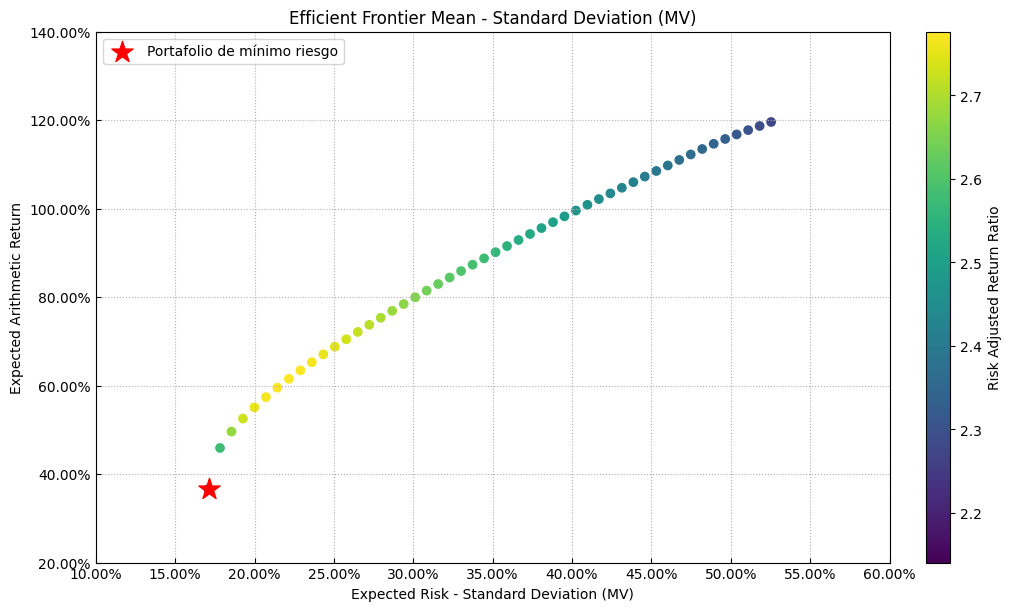

In [5]:
# Graficando la frontera eficiente

label = 'Portafolio de mínimo riesgo' # Título del punto
mu = port.mu # Retornos esperados
cov = port.cov # Matriz de covarianza
returns = port.returns # Retornos de los activos

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

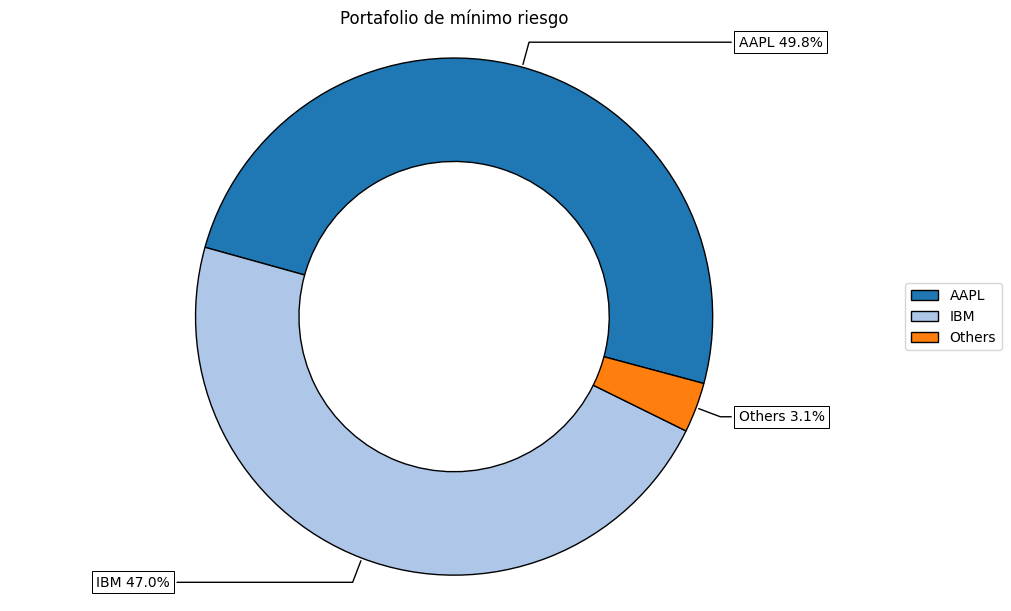

In [6]:
ax = rp.plot_pie(w=w, title='Portafolio de mínimo riesgo', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

## Sharpe

Se cambia la función objetivo para maximizar el ratio de Sharpe.

In [7]:
import riskfolio as rp

# Construyendo el objeto portafolio
port = rp.Portfolio(returns=retornos)

# Calculando el portafolio óptimo

# Seleccionar método y estimar parámetros de entrada:

method_mu='hist' # Método para estimar los retornos esperados basado en datos históricos.
method_cov='hist' # Método para estimar la matriz de covarianza basado en datos históricos.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimar portafolio óptimo:

model='Classic' # Puede ser Classic (histórico), BL (Black Litterman) o FM (Factor Model)
rm = 'MV' # Medida de riesgo utilizada, esta vez será la varianza
obj = 'Sharpe' # Función objetivo, puede ser MinRisk, MaxRet, Utility o Sharpe
hist = True # Usar escenarios históricos para medidas de riesgo que dependen de escenarios
rf = 0 # Tasa libre de riesgo
l = 0 # Factor de aversión al riesgo, solo útil cuando obj es 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,IBM,INTC,NVDA,TSLA
weights,0.257684,0.411533,9.662053e-11,0.263019,0.067764


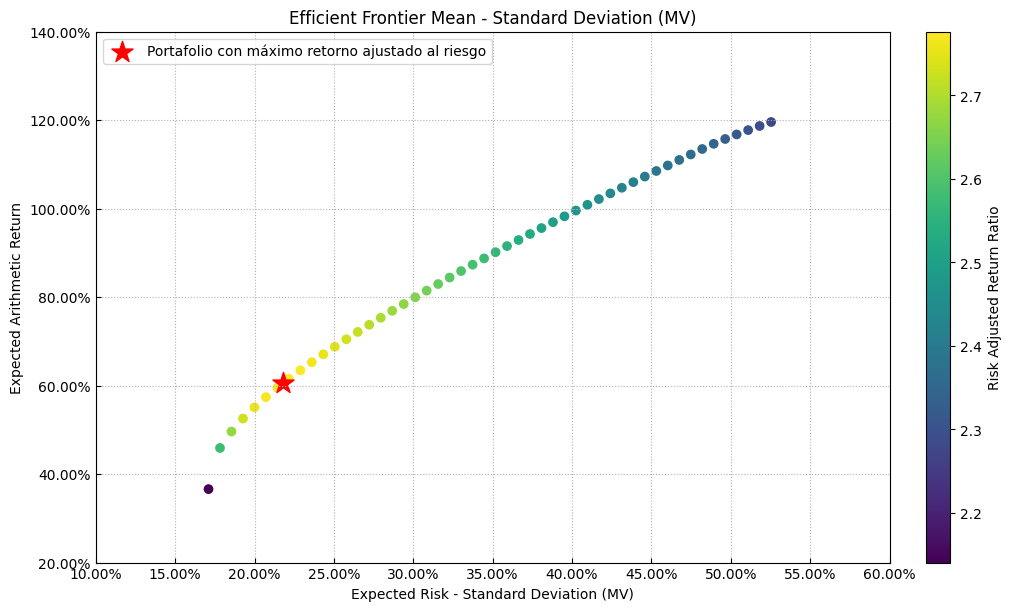

In [8]:
points = 50 # Número de puntos de la frontera

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

# Graficando la frontera eficiente

label = 'Portafolio con máximo retorno ajustado al riesgo' # Título del punto
mu = port.mu # Retornos esperados
cov = port.cov # Matriz de covarianza
returns = port.returns # Retornos de los activos

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

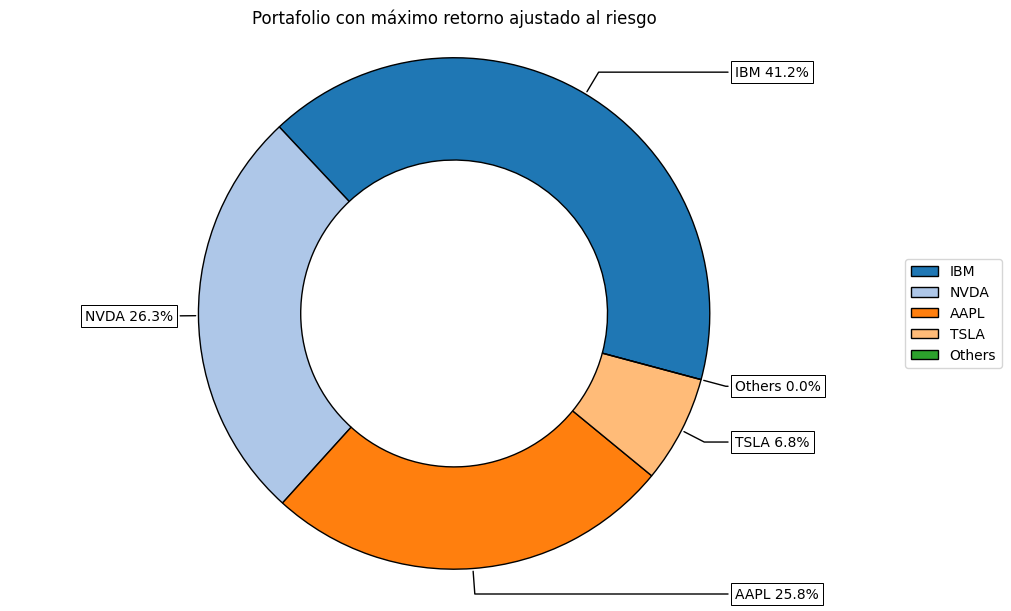

In [9]:
ax = rp.plot_pie(w=w, title='Portafolio con máximo retorno ajustado al riesgo', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

## CVar

Se cambia la medida de riesgo a Conditional Value at Risk (CVaR).

In [10]:
rm = 'CVaR' # Medida de riesgo

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,IBM,INTC,NVDA,TSLA
weights,0.100628,0.478503,2.745833e-11,0.40248,0.018388


In [11]:
points = 50 # Número de puntos de la frontera

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,IBM,INTC,NVDA,TSLA
0,0.409696,0.490586,2.146939e-11,0.034936,0.064782
1,0.373086,0.452795,5.089398e-12,0.132678,0.041441
2,0.384791,0.405722,1.083809e-11,0.186805,0.022682
3,0.312782,0.438461,3.537803e-13,0.219171,0.029586
4,0.240773,0.471200,3.718974e-12,0.251537,0.036489


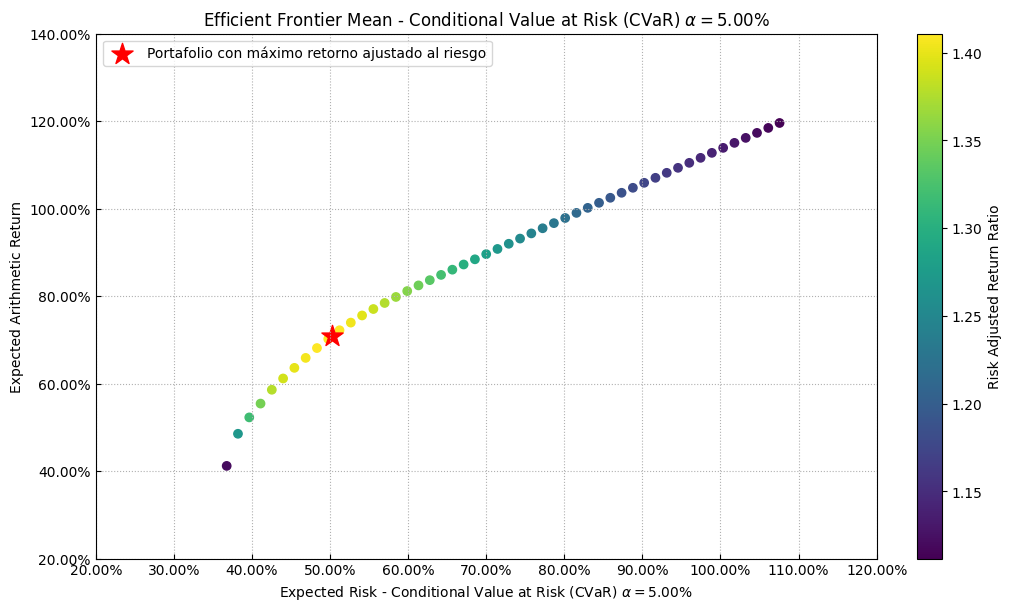

In [12]:
label = 'Portafolio con máximo retorno ajustado al riesgo' # Título del punto

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

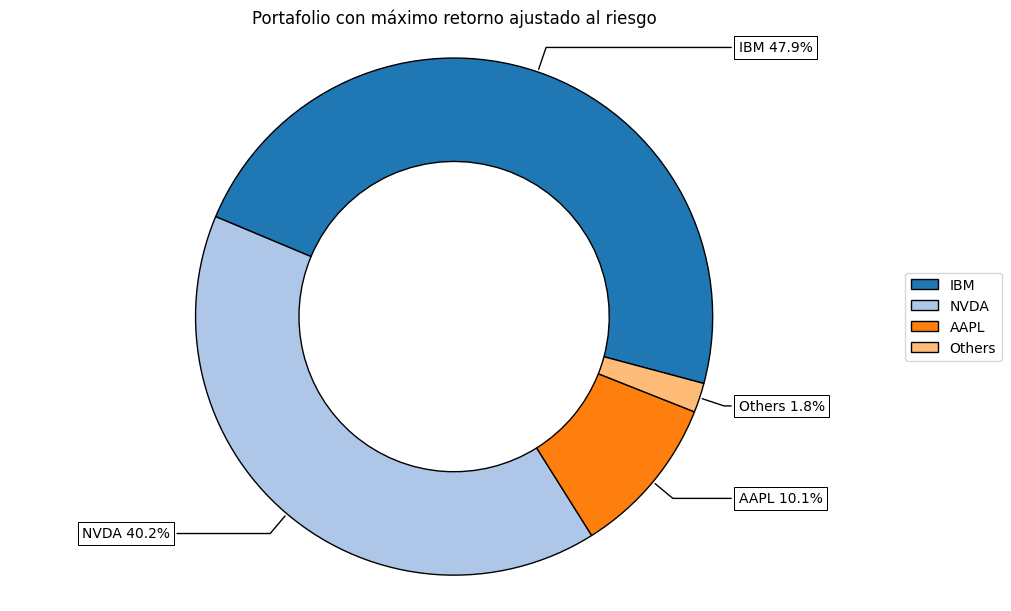

In [13]:
ax = rp.plot_pie(w=w, title='Portafolio con máximo retorno ajustado al riesgo', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

## Risk Parity

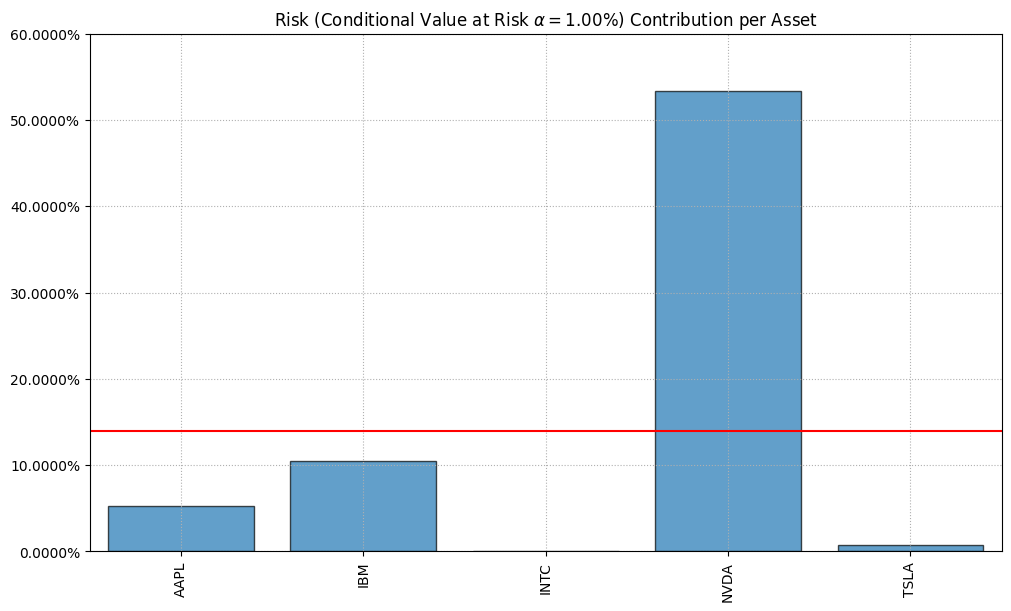

In [14]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

In [15]:
b = None # Risk contribution constraints vector
rm = 'MV' # Medida de riesgo utilizada, esta vez será la varianza

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,AAPL,IBM,INTC,NVDA,TSLA
weights,0.299789,0.336993,0.124699,0.126728,0.111791


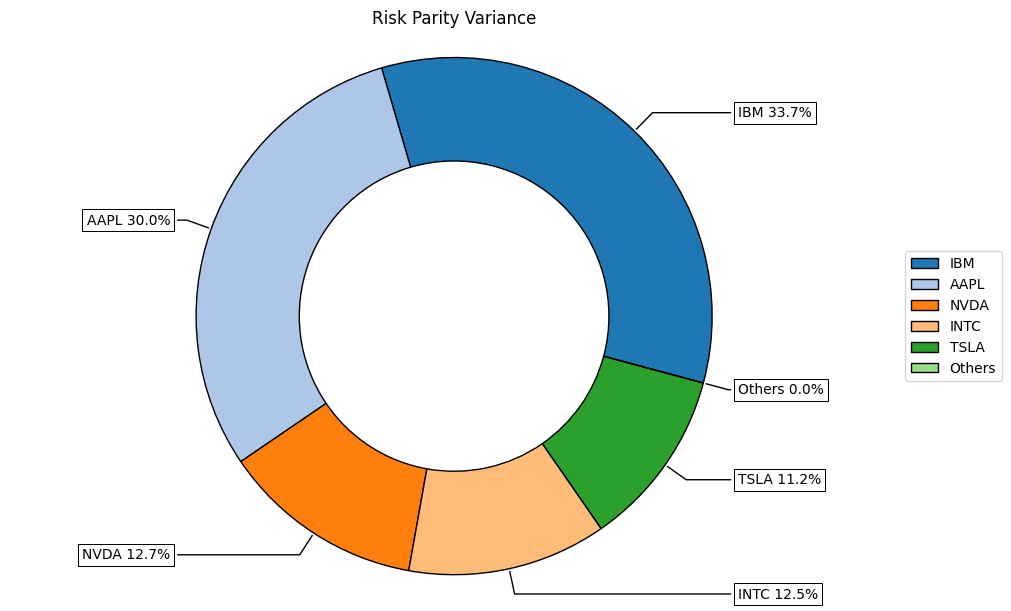

In [16]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

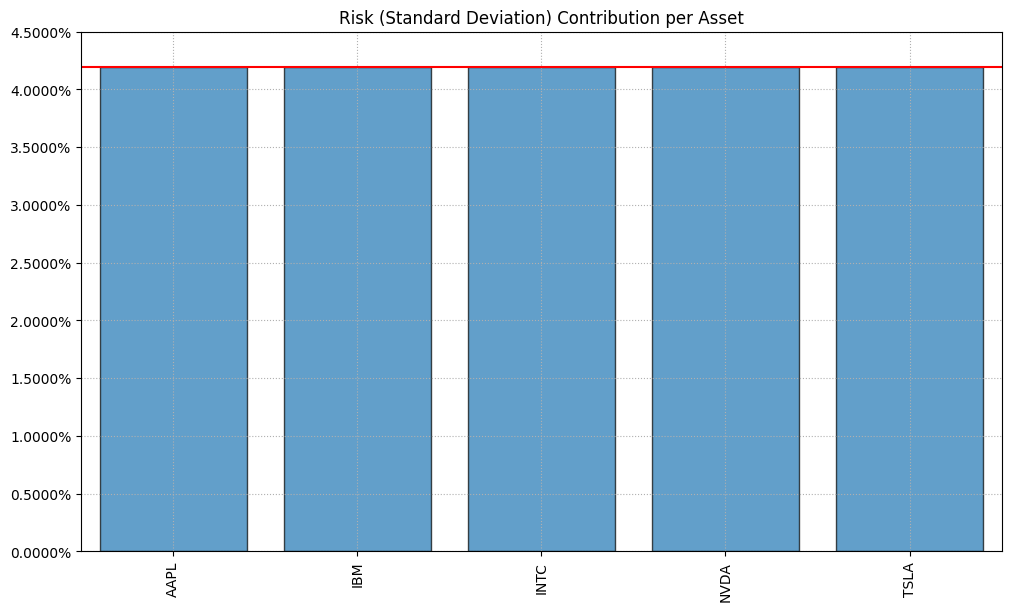

In [17]:
ax = rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

## Black–Litterman (BL)

In [18]:
asset_classes = {'Assets': ["TSLA", "IBM", "AAPL", "NVDA", "INTC"],
                 'Industry': ['Automovil','Tecnologia','Tecnologia',
                              'Procesadores', 'Procesadores']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

views = {'Disabled': [False, False],
         'Type': ['Classes', 'Classes'],
         'Set': ['Industry', 'Industry'],
         'Position': ['Automovil', 'Procesadores'],
         'Sign': ['>=', '>='],
         'Weight': [0.6, 0.6], # Annual terms
         'Type Relative': ['Classes', 'Classes'],
         'Relative Set': ['Industry', 'Industry'],
         'Relative': ['Tecnologia', 'Tecnologia']}

views = pd.DataFrame(views)

display(views)

display(asset_classes)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative
0,False,Classes,Industry,Automovil,>=,0.6,Classes,Industry,Tecnologia
1,False,Classes,Industry,Procesadores,>=,0.6,Classes,Industry,Tecnologia


,Assets,Industry
2,AAPL,Tecnologia
1,IBM,Tecnologia
4,INTC,Procesadores
3,NVDA,Procesadores
0,TSLA,Automovil


In [19]:
P, Q = rp.assets_views(views, asset_classes)

display(pd.DataFrame(P.T))
display(pd.DataFrame(Q))

,0,1
0,-0.5,-0.5
1,-0.5,-0.5
2,0.0,0.5
3,0.0,0.5
4,1.0,0.0


,0
0,0.6
1,0.6


In [20]:
# Estimar las entradas de Black Litterman:

port.blacklitterman_stats(P, Q/252, rf=rf, w=w, delta=None, eq=True)

# Estimar portafolio óptimo:

model='BL'# Black Litterman
rm = 'MV' # Medida de riesgo utilizada, esta vez será la varianza
obj = 'Sharpe' # Función objetivo, puede ser MinRisk, MaxRet, Utility o Sharpe
hist = False # Usar escenarios históricos para medidas de riesgo que dependen de escenarios

w_bl = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w_bl.T)

,AAPL,IBM,INTC,NVDA,TSLA
weights,0.075013,0.45076,3.831484e-10,0.393558,0.08067


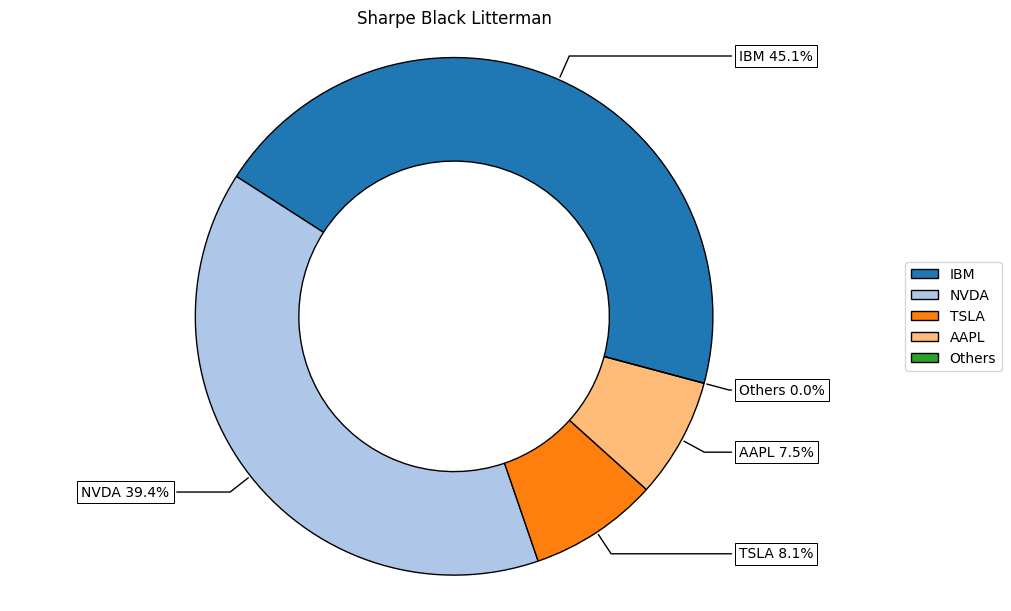

In [21]:

ax = rp.plot_pie(w=w_bl, title='Sharpe Black Litterman', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [22]:
points = 50 # Número de puntos de la frontera

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

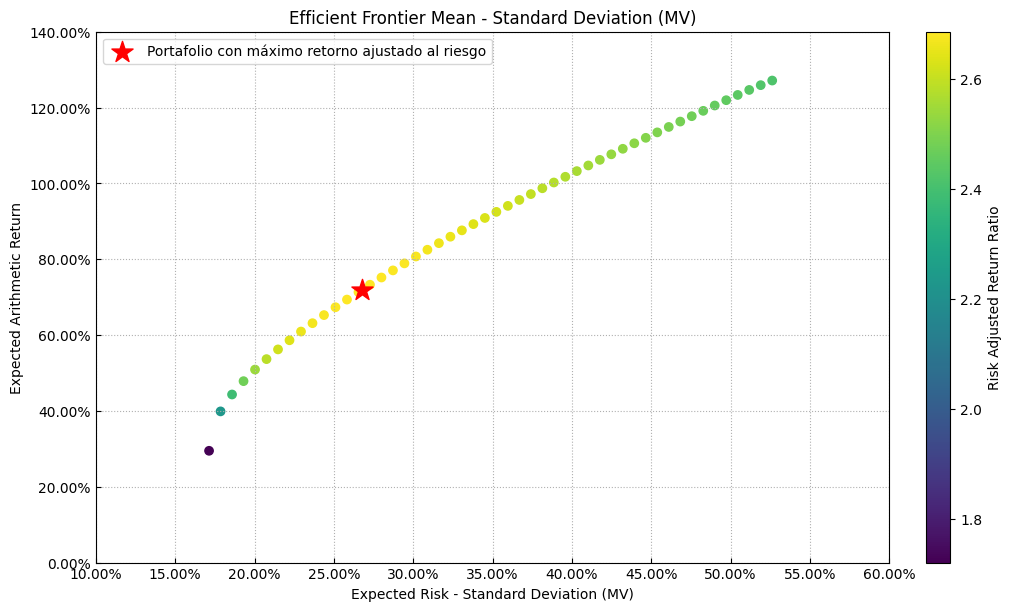

In [23]:
# Graficando la frontera eficiente

label = 'Portafolio con máximo retorno ajustado al riesgo' # Título del punto
mu = port.mu_bl # Retornos esperados del modelo Black Litterman
cov = port.cov_bl # Matriz de covarianza del modelo Black Litterman
returns = port.returns # Retornos de los activos

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_bl, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)